In [113]:
import numpy as np
import pandas as pd
import glob
from astropy.io import fits
import matplotlib.pylab as plt
import random

In [114]:
injections_table = pd.read_csv('/mnt_home/zoek/code/APF-BL-DAP/Zoe/AnnaInjection/Injection_key_full.csv')
star_names = injections_table['Star_name'].tolist()

results_table = pd.read_csv('/mnt_home/zoek/code/APF-BL-DAP/Zoe/AnnaInjectionResults/final_results.csv')

In [115]:
# look at Anna's injections for a specfic star
injections_table[injections_table['Star_name'] == 'GJ702B']

,Star_name,Injection_wavelength,Injected_peak_photons,Local_median_photons
27,GJ702B,5490.074136,164158.149023,105022.593750
28,GJ702B,5555.365277,223767.865781,108709.835938
29,GJ702B,5622.229265,340678.847578,111627.902344


In [116]:
# these are all the wavelengths anna injected in
rounded_wavelength_vals = np.round(injections_table['Injection_wavelength'].unique())

In [120]:
# look at the stars that have detections at the locations anna injected in

# first get the stars that have both spectra and residuals
sub = results_table.dropna(subset=['s shifted wl', 'r shifted wl'])

# find the stars that have detections at the wavelengths anna injected into
has_injections = sub[np.round(sub['s unshifted wl']).isin(rounded_wavelength_vals)]

counts = pd.DataFrame(has_injections.star.value_counts()).rename(columns = {'star':'count'})
stars_with_three_recoveries = counts[counts['count'].isin(np.array([3, 4]))].index
stars_with_two_recoveries = counts[counts['count'] == 2].index
stars_with_one_recovery = counts[counts['count'] == 1].index

has_injections

,Unnamed: 0,star,s shifted wl,s unshifted wl,s heights,r shifted wl,r unshifted wl,r heights
235,576,GJ144,5620.392622,5622.219559,1.427364,5620.392622,5622.219559,1.428376
497,1495,GJ702B,5554.289637,5555.361482,1.990619,5554.289637,5555.361482,1.991948
498,1494,GJ702B,5489.019995,5490.079244,1.377499,5489.019995,5490.079244,1.432449
499,1496,GJ702B,5621.155666,5622.240414,2.853890,5621.155666,5622.240414,2.832923
500,1622,GJ768,5490.063315,5490.081899,1.448781,5490.063315,5490.081899,1.450853
...,...,...,...,...,...,...,...,...
11277,4892,HIP75829,5525.429412,5526.776355,3.782340,5525.429412,5526.776355,3.709471
11278,4891,HIP75829,5460.480380,5461.811490,1.211339,5460.480380,5461.811490,1.290502
11279,5204,HIP76219,5590.600708,5593.289148,5.646371,5590.600708,5593.289148,5.479983
11280,5203,HIP76219,5524.098144,5526.754604,3.687597,5524.098144,5526.754604,3.686579


In [126]:
# number of stars with all 3 recoveries, only 2, or only 1

len(stars_with_three_recoveries)
len(stars_with_two_recoveries)
len(stars_with_one_recovery)

6

In [118]:
stars_with_detections = list(counts.index)
len(stars_with_detections)

314

In [119]:
stars_with_residuals = list(sub['star'].unique())
len(stars_with_residuals)

317

In [112]:
# these are the stars that have residuals but have no 
# detections at the wavelengths anna injected them into

for star in stars_with_residuals:
    if not star in stars_with_detections:
        print(star)

HIP31703
HIP40875
HIP70952


In [37]:
# number of detections each star received after going through my detection alg

num_detections_table = pd.DataFrame(results_table.star.value_counts())
num_detections_table.rename(columns={'star': 'count'}, inplace=True)

# just look at the one with 3 total detections - assuming these should be anna's injections
num_detections_table[num_detections_table['count'] == 3]

,count
HIP73695,3
HIP15411,3
HIP69989,3
HIP12777,3
GJ702B,3
...,...
HIP112935,3
HIP25278,3
HIP112915,3
HIP26366,3


In [5]:
stars = []
spectra_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_testing_inj_0'
s_list_of_files = []
for name in glob.glob(spectra_folder + '/*'):
    s_list_of_files += [name]
    
for index in np.arange(0, len(s_list_of_files) - 1):
    star = fits.open(s_list_of_files[index])[0].header['TOBJECT']
    stars += [star]

In [30]:
def to_float(x):
    # helpfer function to convert all NaN values in an array to 0
    try:
        int(x)
        return float(x)
    except ValueError:
        return 0

def close_enough(value, list_values, error_range):
    # given a value and a list of values, find the closes value in the list to that value
    # and return it if the difference between the two values is less than the error_range
    # also return the index corresponding to this value
    
    array = np.asarray(list_values)
    array = np.array([to_float(x) for x in array])
    if len(array) == 0:
        return
    idx = (np.abs(array - value)).argmin()
    closest_value = array[idx]
    
    difference = abs(closest_value - value)
    if difference <= error_range:
        return closest_value, idx

In [31]:
# injections_table

In [32]:
all_s_wls = []
all_s_heights = []
all_r_wls = []
all_r_heights = []

error_range = 1

# injections_table = injections_table.reset_index()
for index, row in injections_table.iterrows():
    star_name = row['Star_name']
    injection_wl = row['Injection_wavelength']
    sub_table = results_table[results_table['star'] == star_name]
    
    s_wls = sub_table['s unshifted wl']
    s_heights = sub_table['s heights']

    r_wls = sub_table['r unshifted wl']
    r_heights = sub_table['r heights']
    
    s_wl = 0
    r_wl = 0
    s_height = 0
    r_height = 0

    if close_enough(injection_wl, s_wls, error_range):
        s_wl, index = close_enough(injection_wl, s_wls, error_range)
        s_height = list(s_heights)[index]

    if close_enough(injection_wl, r_wls, error_range):
        r_wl, index = close_enough(injection_wl, r_wls, error_range)
        r_height = list(r_heights)[index]
        
    all_s_wls += [s_wl]
    all_s_heights += [s_height]
    all_r_wls += [r_wl]
    all_r_heights += [r_height]

In [33]:
# all_s_wls = []
# all_s_heights = []
# all_r_wls = []
# all_r_heights = []

# error_range = 1

# # injections_table = injections_table.reset_index()
# index = 245
# row = injections_table.iloc[245]

# star_name = row['Star_name']
# injection_wl = row['Injection_wavelength']
# sub_table = results_table[results_table['star'] == star_name]

# s_wls = sub_table['s unshifted wl']
# s_heights = sub_table['s heights']

# r_wls = sub_table['r unshifted wl']
# r_heights = sub_table['r heights']

# s_wl = 0
# r_wl = 0
# s_height = 0
# r_height = 0

# if close_enough(injection_wl, s_wls, error_range):
#     s_wl, index = close_enough(injection_wl, s_wls, error_range)
#     s_height = list(s_heights)[index]

# if close_enough(injection_wl, r_wls, error_range):
#     r_wl, index = close_enough(injection_wl, r_wls, error_range)
#     r_height = list(r_heights)[index]

# all_s_wls += [s_wl]
# all_s_heights += [s_height]
# all_r_wls += [r_wl]
# all_r_heights += [r_height]

In [34]:
injections_table['Detected_spectrum_wavelength'] = all_s_wls
injections_table['Detected_spectrum_height'] = all_s_heights

injections_table['Detected_residual_wavelength'] = all_r_wls
injections_table['Detected_residual_height'] = all_r_heights

In [35]:
missing_stars = injections_table.groupby('Star_name').sum()
missing_stars = missing_stars[missing_stars['Detected_spectrum_wavelength'] == 0]
missing_stars = list(set(list(missing_stars.index)))

new_missing_stars = []
for star in missing_stars:
    if star in stars:
        new_missing_stars += [star]

In [36]:
SNR_table = pd.read_csv('/mnt_home/zoek/code/APF-BL-DAP/Zoe/specmatch_results.csv')

In [37]:
SNR_missing_stars = []
for star in new_missing_stars:
    SNR = SNR_table[SNR_table['name'] == star]['SNR']
    if len(list(SNR)) == 0:
        SNR = np.array([0])
#     print(list(SNR))
    SNR_missing_stars += list(SNR)

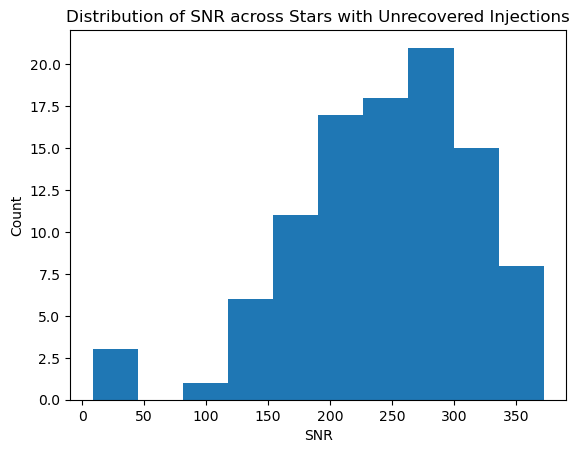

In [38]:
test = pd.DataFrame({'star': new_missing_stars, 'SNR': SNR_missing_stars})
plt.hist(test['SNR'])
plt.xlabel('SNR')
plt.ylabel('Count')
plt.title('Distribution of SNR across Stars with Unrecovered Injections')
plt.show()

In [39]:
stars = list(test[test['SNR'] > 50]['star'])
velshifts = pd.read_csv('/mnt_home/zoek/code/APF-BL-DAP/Zoe/RestWavelengths/velshifts.csv')

In [40]:
injections_table.groupby('Injection_wavelength').count()

,Star_name,Injected_peak_photons,Local_median_photons,Detected_spectrum_wavelength,Detected_spectrum_height,Detected_residual_wavelength,Detected_residual_height
Injection_wavelength,,,,,,,
5461.813825,300,300,300,300,300,300,300
5490.074136,300,300,300,300,300,300,300
5526.772620,300,300,300,300,300,300,300
5555.365277,300,300,300,300,300,300,300
5593.298647,300,300,300,300,300,300,300
5622.229265,300,300,300,300,300,300,300


In [53]:
len(stars)

97

In [428]:
test_vals = velshifts.loc[velshifts['Star name'].isin(stars)]['Velocity_shift [km/s]']

In [433]:
plt.hist(test_vals)
test_vals

70      69.511285
88      54.797218
110     80.166300
232    135.470899
290     58.348889
441    109.087054
493     79.658918
515      3.044290
557     10.655015
567    117.712542
598     93.865605
642      1.014763
Name: Velocity_shift [km/s], dtype: float64

In [399]:
injections_table[injections_table['Star_name'] == 'HIP108036']

,Star_name,Injection_wavelength,Injected_peak_photons,Local_median_photons,Detected_spectrum_wavelength,Detected_spectrum_height,Detected_residual_wavelength,Detected_residual_height
243,HIP108036,5490.074136,186672.309609,117469.910156,0.0,0.0,0.0,0.0
244,HIP108036,5555.365277,251368.792031,121134.113281,0.0,0.0,0.0,0.0
245,HIP108036,5622.229265,378343.707891,122981.738281,0.0,0.0,0.0,0.0


In [400]:
sum(injections_table['Detected_residual_wavelength'] != 0)

905

# Plotting

In [401]:
list1 = []
spectra_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_testing_inj_0'
s_list_of_files = []
for name in glob.glob(spectra_folder + '/*'):
    s_list_of_files += [name]
    
random_indicies = random.sample(range(0, len(s_list_of_files) - 1), 10)

for index in np.arange(0, len(s_list_of_files) - 1):
    star = fits.open(s_list_of_files[index])[0].header['TOBJECT']
#     if star in star_names:
    if True:
        
        list1 += [star]
        
#         fl = fits.open(s_list_of_files[index])[0].data
#         wl = fits.open(s_list_of_files[index])[1].data
#         plt.plot(wl, fl)
#         plt.xlabel('Wavelength')
#         plt.ylabel('Flux')
#         plt.title(star)
#         plt.show()

In [72]:
list2 = []

residuals_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_testing_inj_0'
r_list_of_files = []
for name in glob.glob(residuals_folder + '/*'):
    r_list_of_files += [name]
    
random_indicies = random.sample(range(0, len(r_list_of_files) - 1), 10)

for index in np.arange(0, len(r_list_of_files) - 1):
    star = fits.open(r_list_of_files[index])[0].header['TOBJECT']
#     if star in star_names:
    if True:
        
        list2 += [star]
        
#         fl = fits.open(r_list_of_files[index])[1].data
#         wl = fits.open(r_list_of_files[index])[2].data
#         plt.plot(wl, fl)
#         plt.xlabel('Wavelength')
#         plt.ylabel('Flux')
#         plt.title(star)
#         plt.show()

In [326]:
len(list2)

500

In [42]:
list3 = []

spectra_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_all_apf'
s_list_of_files = []
for name in glob.glob(spectra_folder + '/*'):
    s_list_of_files += [name]
    
random_indicies = random.sample(range(0, len(s_list_of_files) - 1), 10)

for index in np.arange(0, len(s_list_of_files) - 1):
    star = fits.open(s_list_of_files[index])[0].header['TOBJECT']
    if star in star_names:
        
        list3 += [star]
        
        fl = fits.open(s_list_of_files[index])[0].data
        wl = fits.open(s_list_of_files[index])[1].data
        plt.plot(wl, fl)
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.title(star)
#         plt.show()

In [49]:
list4 = []

residuals_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_all_apf'
r_list_of_files = []
for name in glob.glob(residuals_folder + '/*'):
    r_list_of_files += [name]
    
random_indicies = random.sample(range(0, len(r_list_of_files) - 1), 10)

for index in np.arange(0, len(r_list_of_files)):
    star = fits.open(r_list_of_files[index])[0].header['TOBJECT']
    if star in star_names:
        
        list4 += [star]
        
        fl = fits.open(r_list_of_files[index])[1].data
        wl = fits.open(r_list_of_files[index])[2].data
        plt.plot(wl, fl)
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.title(star)
#         plt.show()

In [51]:
list5 = []
for star in list1:
    if star in list2 and star in list3 and star in list4:
        list5 += [star]

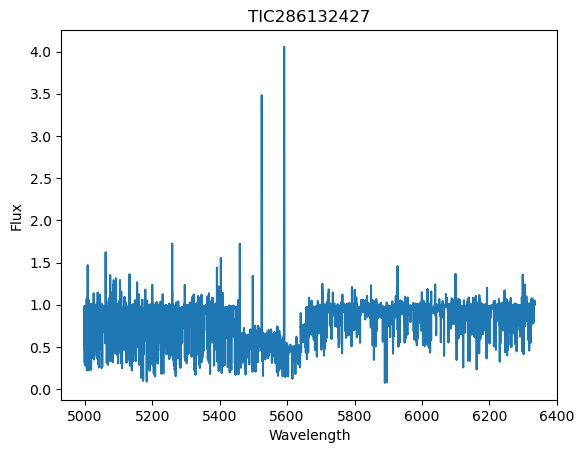

In [81]:
spectra_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_testing_inj_0'
s_list_of_files = []
for name in glob.glob(spectra_folder + '/*'):
    s_list_of_files += [name]
    
for index in np.arange(0, len(s_list_of_files) - 1):
    star = fits.open(s_list_of_files[index])[0].header['TOBJECT']
    if star == 'TIC286132427':    
        fl = fits.open(s_list_of_files[index])[0].data
        wl = fits.open(s_list_of_files[index])[1].data
        plt.plot(wl, fl)
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.title(star)
        plt.show()

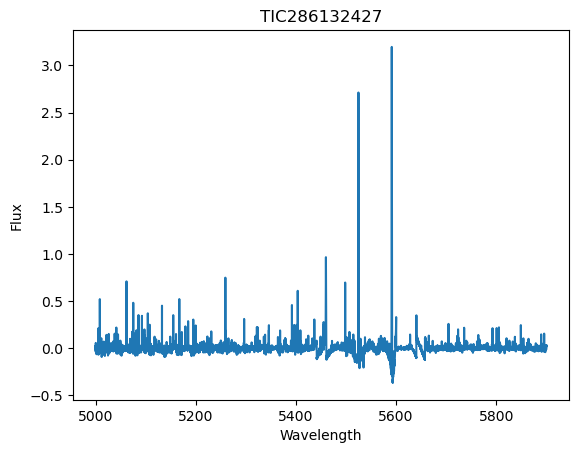

In [82]:
residuals_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_testing_inj_0'
r_list_of_files = []
for name in glob.glob(residuals_folder + '/*'):
    r_list_of_files += [name]
    
for index in np.arange(0, len(r_list_of_files) - 1):
    star = fits.open(r_list_of_files[index])[0].header['TOBJECT']
    if star == 'TIC286132427':
        fl = fits.open(r_list_of_files[index])[1].data
        wl = fits.open(r_list_of_files[index])[2].data
        plt.plot(wl, fl)
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.title(star)
        plt.show()

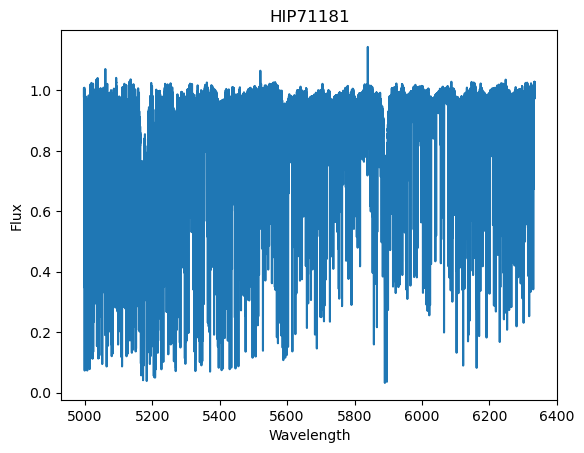

In [375]:
spectra_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRS_all_apf'
s_list_of_files = []
for name in glob.glob(spectra_folder + '/*'):
    s_list_of_files += [name]
    
for index in np.arange(0, len(s_list_of_files) - 1):
    star = fits.open(s_list_of_files[index])[0].header['TOBJECT']
    if star == 'HIP71181':
        fl = fits.open(s_list_of_files[index])[0].data
        wl = fits.open(s_list_of_files[index])[1].data
        plt.plot(wl, fl)
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.title(star)
        plt.show()

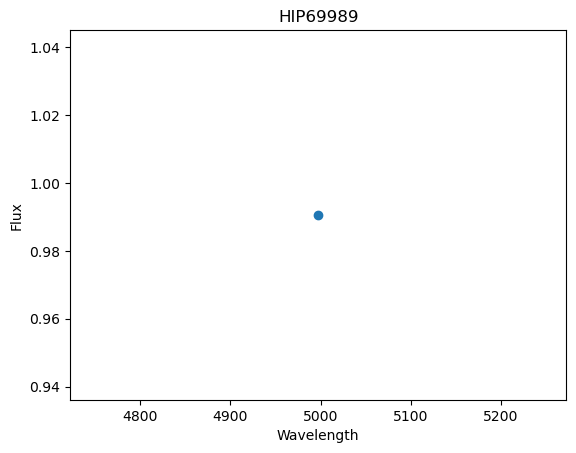

0.01696052432362194


In [379]:
plt.scatter(wl[1], fl[1])
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title(star)
plt.show()

print(wl[2]-wl[1])

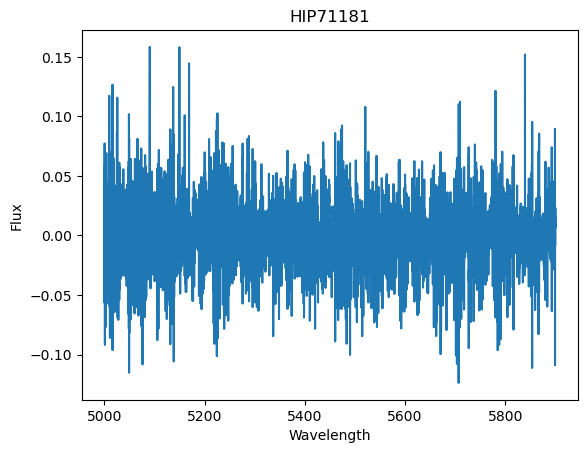

In [374]:
residuals_folder = '/mnt_home/azuckerman/BL_APF_DAP/APF_spectra/NDRR_all_apf'
r_list_of_files = []
for name in glob.glob(residuals_folder + '/*'):
    r_list_of_files += [name]
    
random_indicies = random.sample(range(0, len(r_list_of_files) - 1), 10)

for index in np.arange(0, len(r_list_of_files)):
    star = fits.open(r_list_of_files[index])[0].header['TOBJECT']
    if star == 'HIP71181':
        fl = fits.open(r_list_of_files[index])[1].data
        wl = fits.open(r_list_of_files[index])[2].data
        plt.plot(wl, fl)
        plt.xlabel('Wavelength')
        plt.ylabel('Flux')
        plt.title(star)
        plt.show()